<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/VGG_SBDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras,os
import cv2
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model,load_model
from keras import layers
from keras import regularizers
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.layers import Concatenate
from keras.initializers import glorot_uniform
from keras import regularizers

In [ ]:
!unzip -qq images.zip

In [ ]:
!unzip -qq labels.zip

In [2]:
from PIL import Image
from numpy import *
images_folder= "images/*.jpg"
labels_folder = "labels/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  class_label=[]
  label = []
  files = glob.glob (images_folder)
  for myFile in files[:6000]:
      image_name=os.path.split(myFile)[1]
      class_label.append(float(image_name[0]))
      image = array(Image.open(myFile))
      label_image = array(Image.open(labels_folder+image_name))
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  class_label=np.array(class_label) 
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2],label.shape[3]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  return class_label,label,total_img

In [3]:
class_labels,total_labels,total_images=data_preprocessing(images_folder,labels_folder)

In [4]:
total_images.shape

(6000, 224, 224, 3)

In [40]:
def identifier(x,name=None):
  #layer = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same',activation="relu")(x)
  layer = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same',activation="relu")(x)
  layer = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same',activation="relu")(layer)
  layer = layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same',activation="relu")(layer)
  layer = layers.Conv2DTranspose(3, (3, 3), strides=(2, 2),activation="relu", padding="same")(layer)
  layer = layers.Conv2DTranspose(3, (3, 3), strides=(1, 1),activation="sigmoid", padding="same")(layer)
  layer = layers.Conv2DTranspose(3, (3, 3), strides=(1, 1),activation="sigmoid", padding="same", name=name)(layer)
  return layer

In [51]:
def vggnet():
    layer_in = Input(shape=(224, 224, 3))
    #layer 1
    layer = layers.Conv2D(64,(3,3),padding="same", activation="relu",kernel_initializer=glorot_uniform(seed=0))(layer_in)
    layer = layers.Conv2D(64,(3,3),padding="same", activation="relu")(layer)
    layer = layers.MaxPool2D((2,2),strides=(2,2))(layer)
    #layer 2
    layer = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(layer)
    #layer 3
    layer = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(layer)
    #layer 4
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(layer)
    # layer 5
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    ident  = identifier(layer, name='ident')
    #layer = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(layer)
    #ident = layers.UpSampling2D(size=(32, 32),name="ident")(layer)

    #layer = layers.Flatten()(layer)
    #layer = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(layer)
    #layer = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(layer)
    #main = layers.Dense(units=1, activation="sigmoid",name="main",kernel_initializer=glorot_uniform(seed=0))(layer)
    model = Model(inputs=layer_in, outputs=ident,name='vggnet')
    return model

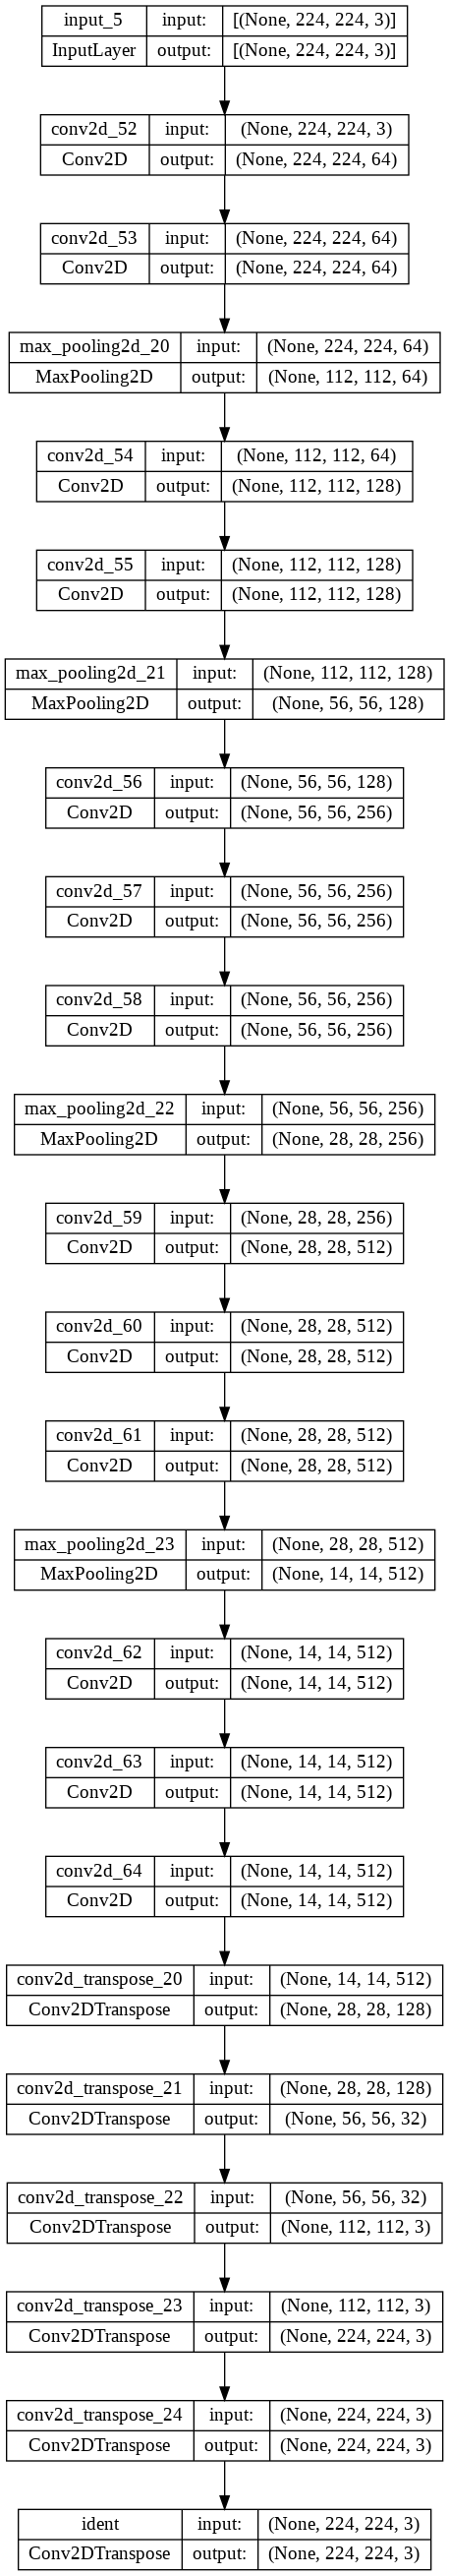

In [52]:
model=vggnet()
keras.utils.plot_model(model, show_shapes=True)

In [53]:
loss1=tf.keras.losses.BinaryCrossentropy()
loss2=tf.keras.losses.MeanSquaredError()
model.compile(keras.optimizers.Adam(learning_rate=1e-3),loss = [loss2],metrics=["accuracy"])

In [54]:
class_label=class_labels[:4000]
x_train = total_images[:4000].astype(np.float32)/ 255.0
y_train=total_labels[:4000].astype(np.float32)/ 255.0
y_train =(class_label,y_train)

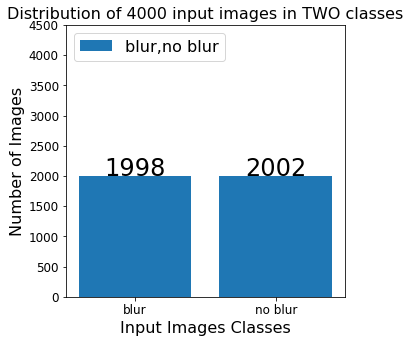

In [13]:
unique, counts = np.unique(class_label, return_counts=True)
import matplotlib.pyplot as plt
def addlabels(x,y):
	for i in range(len(x)):
		plt.text(i,y[i],y[i],fontsize=24, ha='center')
if __name__ == '__main__':
	# creating data on which bar chart will be plot
	x = ['blur','no blur']
	y = [counts[0],counts[1]]
plt.figure(figsize=(5,5))
plt.bar(x, y,label='blur,no blur')
addlabels(x, y)
plt.title(f"Distribution of {(class_label.shape)[0]} input images in TWO classes",fontsize=16)
plt.xlabel('Input Images Classes',fontsize=16)
plt.ylabel('Number of Images',fontsize=16)
plt.yticks(np.arange(0, 5000,500),fontsize=12)
plt.xticks(fontsize=12)
plt.gca().legend(prop={'size': 16},loc='upper left',fontsize=14)
plt.show()

In [56]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point
    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["accuracy"]
        if accuracy >= self.point:
            self.model.stop_training = True
callbacks = [StopOnPoint(0.90)]

In [57]:
history = model.fit(x_train,y_train[1], epochs=5,batch_size=25, validation_split=0.2,shuffle=True,callbacks=[callbacks])
model.save('vggnet_model.h5')

Epoch 1/5
  6/128 [>.............................] - ETA: 44s - loss: 0.0716 - accuracy: 0.0618

128/128 [==============================] - 53s 415ms/step - loss: 0.0651 - accuracy: 0.1246 - val_loss: 0.0633 - val_accuracy: 0.1850
Epoch 2/5
128/128 [==============================] - 52s 406ms/step - loss: 0.0645 - accuracy: 0.1719 - val_loss: 0.0632 - val_accuracy: 0.1780
Epoch 3/5
128/128 [==============================] - 53s 412ms/step - loss: 0.0645 - accuracy: 0.2309 - val_loss: 0.0631 - val_accuracy: 0.2859
Epoch 4/5
128/128 [==============================] - 52s 410ms/step - loss: 0.0643 - accuracy: 0.3131 - val_loss: 0.0630 - val_accuracy: 0.3100
Epoch 5/5
128/128 [==============================] - 53s 411ms/step - loss: 0.0643 - accuracy: 0.3116 - val_loss: 0.0630 - val_accuracy: 0.3180


In [16]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'main_loss', 'ident_loss', 'main_accuracy', 'ident_accuracy', 'val_loss', 'val_main_loss', 'val_ident_loss', 'val_main_accuracy', 'val_ident_accuracy'])


In [17]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'vgghistory.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

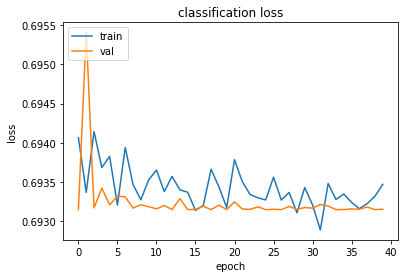

In [ ]:
plt.plot(history.history['main_loss'])
plt.plot(history.history['val_main_loss'])
plt.title('classification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

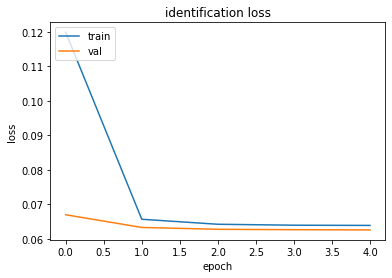

In [18]:
plt.plot(history.history['ident_loss'])
plt.plot(history.history['val_ident_loss'])
plt.title('identification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

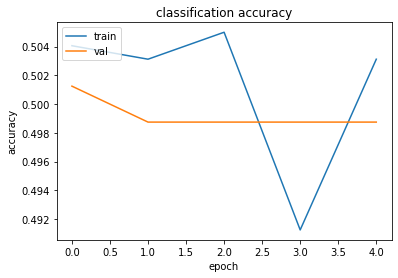

In [19]:
plt.plot(history.history['main_accuracy'])
plt.plot(history.history['val_main_accuracy'])
plt.title('classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

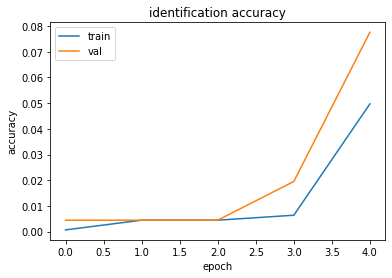

In [20]:
plt.plot(history.history['ident_accuracy'])
plt.plot(history.history['val_ident_accuracy'])
plt.title('identification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
eval_images=total_images[4000:4500]
eval_labels=total_labels[4000:4500]
eval_class_label=class_labels[4000:4500]

In [ ]:
from keras.models import load_model
from PIL import Image
images = eval_images
model = load_model("vggnet_model.h5")
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [46]:
predictions[0][0]

array([[0.49932137]], dtype=float32)

In [47]:
y_pred_class=[]
for i in range(len(predictions)):
  predicted_class=((predictions[i])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  y_pred_class.append(predicted_class)
y_pred_class=np.array(y_pred_class)

Confusion Matrix

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
conf_m = confusion_matrix(eval_class_label, y_pred_class)
conf_m

array([[242,   0],
       [258,   0]])

In [49]:
report = classification_report(eval_class_label, y_pred_class)
print(report)

              precision    recall  f1-score   support

         0.0       0.48      1.00      0.65       242
         1.0       0.00      0.00      0.00       258

    accuracy                           0.48       500
   macro avg       0.24      0.50      0.33       500
weighted avg       0.23      0.48      0.32       500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
def get_iou_score(predictions,eval_labels):
  iou_scores=[]
  for i in range(len(predictions)):
    true_label = eval_labels[i]/255.0
    y_pred_label = np.where((((predictions[i])[1])[0])>0.5,1.0,0.0)
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(true_label, y_pred_label)
    iou_scores.append(m.result().numpy())
  return mean(iou_scores)
iou_score = get_iou_score(predictions,eval_labels)
print('Average Intersection over Union IoU for Blur Detection: ',iou_score )

Average Intersection over Union IoU for Blur Detection:  0.7277247


predicted class vs true class


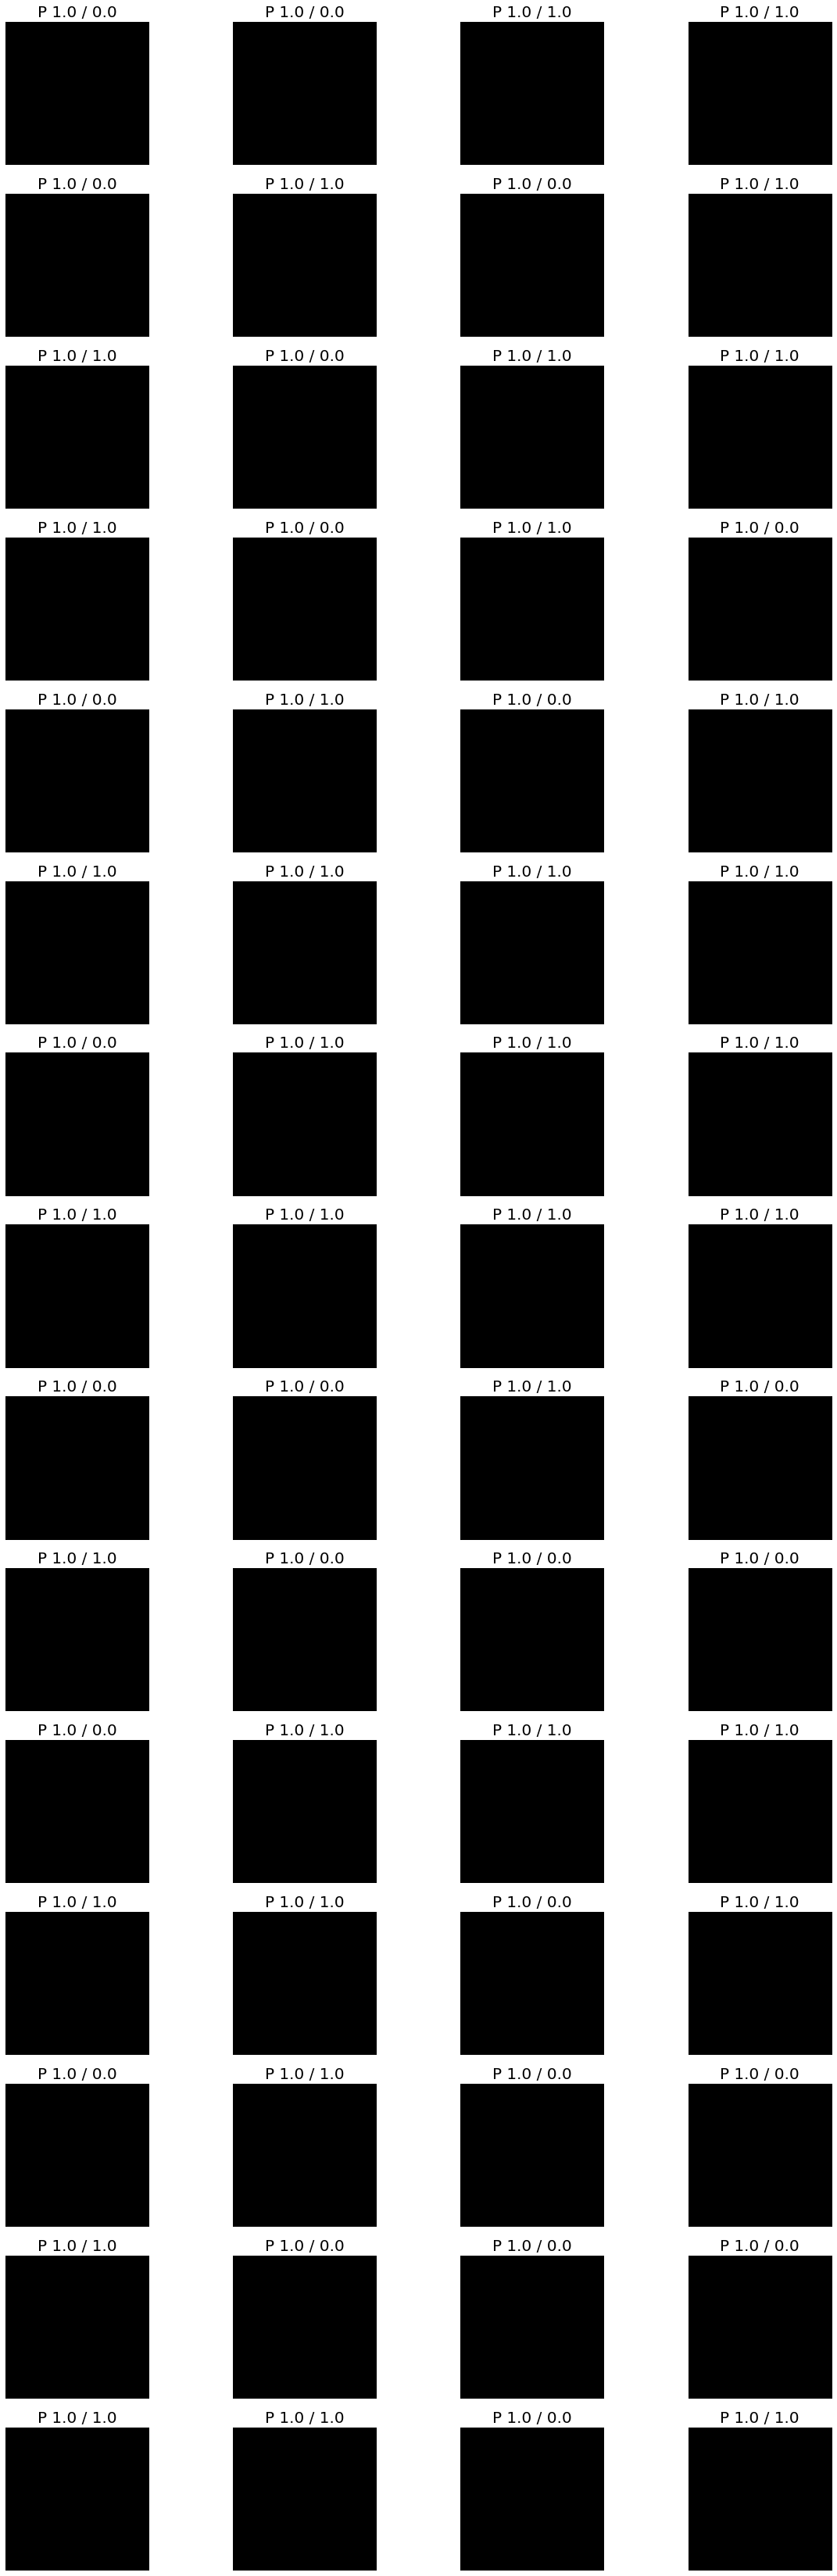

In [39]:
columns = 4
rows = 15
print("predicted class vs true class")
fig = plt.figure(figsize=(20,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[1])[0])>0.5,1.0,0.0)
  plt.imshow((img_pred_label*255.0).astype(np.uint8))
  predicted_class=(((predictions[i])[0])[0])
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=20)
  plt.axis("off")
plt.show()

predicted class vs true class


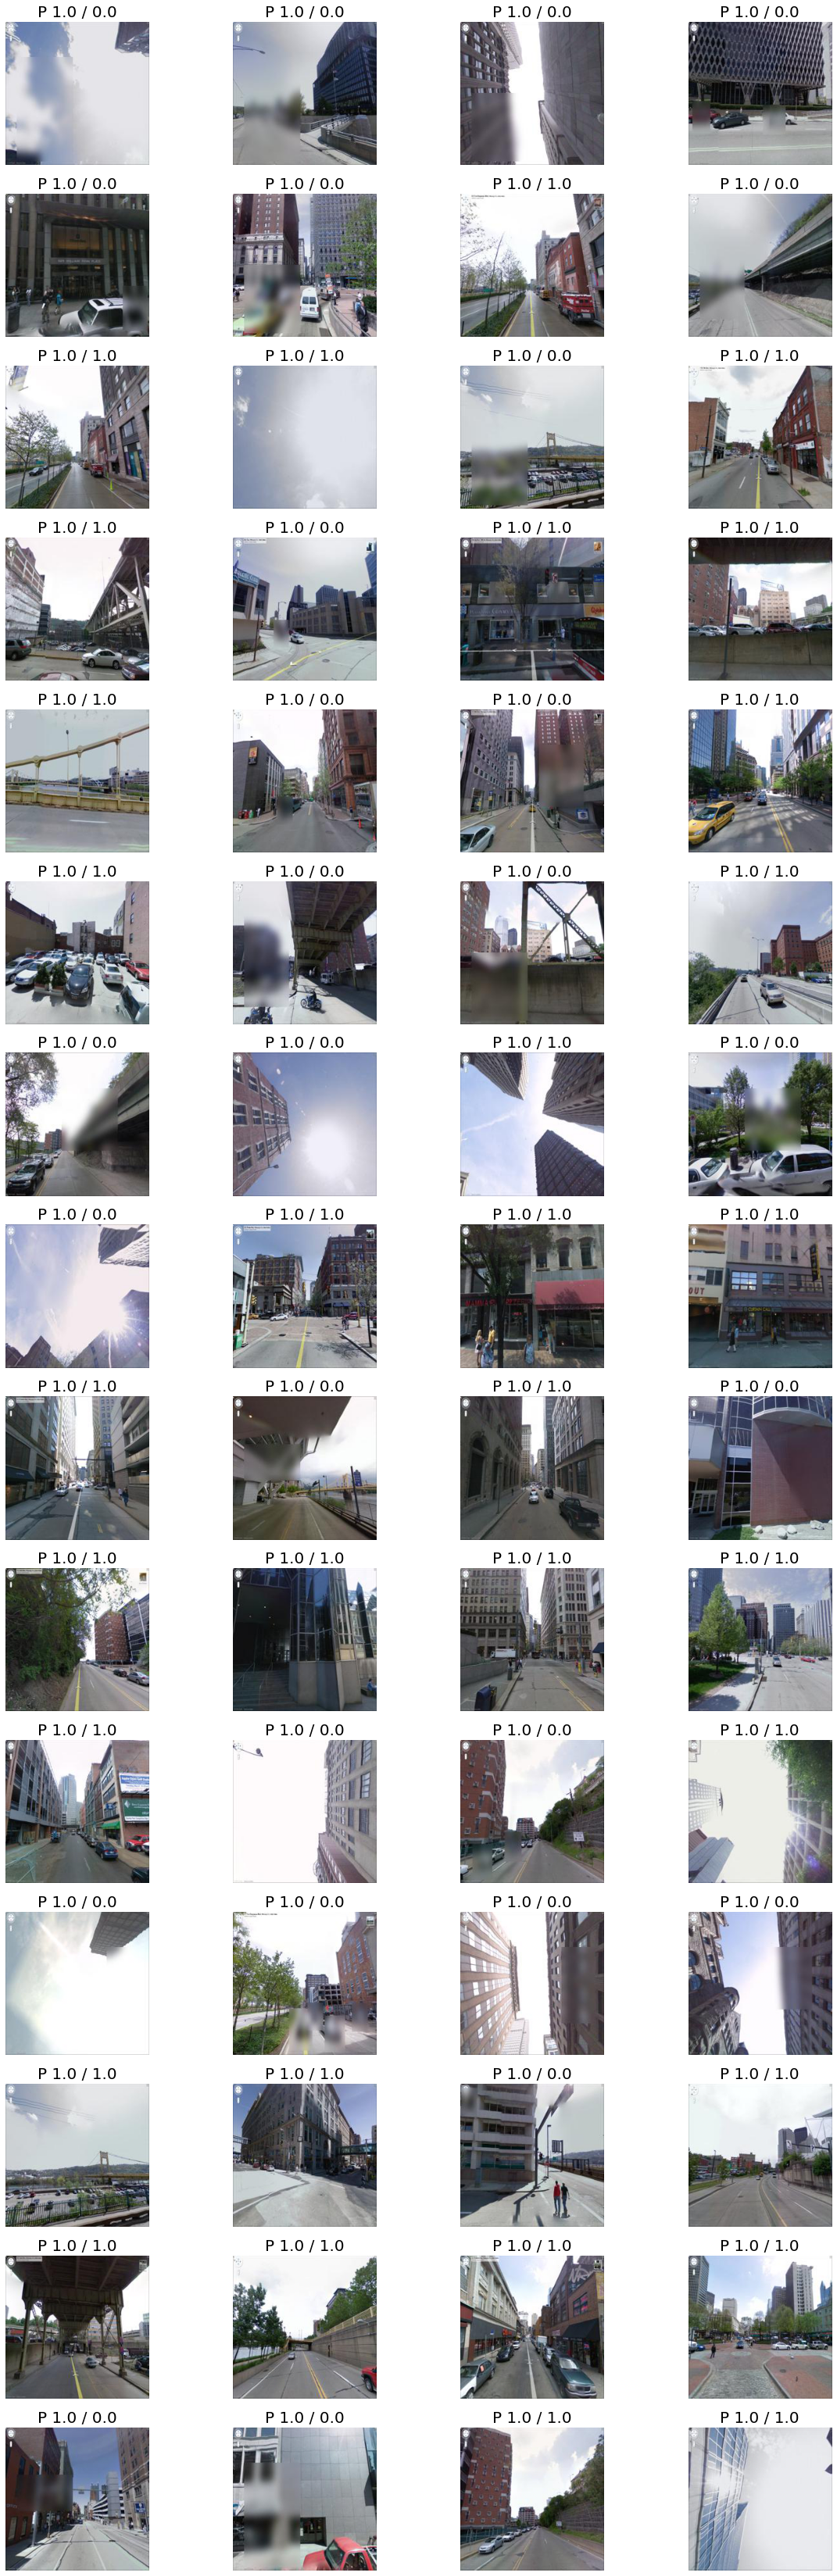

In [ ]:
fig = plt.figure(figsize=(20,60))
columns = 4
rows = 15
print("predicted class vs true class")
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[1])[0])>0.5,1.0,0.0)
  mask=(img_pred_label*255.0).astype(np.uint8)
  blackFrame = np.zeros((224,224, 3), dtype = "uint8")
  whiteFrame = 255 * np.ones((224,224,3), np.uint8)
  #label_img = Image.fromarray(label_img)
  mask = np.where(mask==255,whiteFrame,blackFrame)
  img= images[i]
  cyan = np.full_like(img,(80, 229, 235))
  blend = 0.5
  img_cyan = cv2.addWeighted(img, blend, cyan, 1-blend, 0)
  mask = np.where(mask>=165,img_cyan,img)
  #mask =cv2.cvtColor(mask , cv2.COLOR_BGR2RGB)
  plt.imshow(mask,cmap='binary')
  #mask = Image.fromarray(mask)
  predicted_class=(((predictions[i])[0])[0])
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=20)
  plt.axis("off")
plt.show()